# Задача о разборчивой невесте

## Описание
1. Невеста ищет себе жениха (существует единственное вакантное место).
2. Число претендентов - N.
3. Невеста общается с претендентами в случайном порядке, с каждым не более одного раза.
4. О каждом претенденте известно, лучше он или хуже любого из предыдущих.
5. Пообщавшись с претендентом, невеста сравнивает его с предыдущими и либо отказывает, либо принимает его предложение. Если предложение принято, они женятся и процесс останавливается. Если невеста отказывает жениху, то вернуться к нему позже она не сможет.
6. Невеста выигрывает, если она выберет самого лучшего претендента. Выбор даже второго по порядку сравнения — проигрыш.

## Задача
1. Разработать и обучить нейронную сеть, которая возьмет на себя роль невесты и будет решать принять предложение или отказать очередному жениху.
2. Сравнить результат принятия решения обученной нейронной сети и оптимальным математическим алгоритмом.

## Среда
Это среда, мои чуваки!

In [3]:
import gymnasium as gym
import numpy as np
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.vec_env import VecNormalize, DummyVecEnv
import numpy as np

class BrideEnvironment(gym.Env):
    def __init__(self, num_candidates=100):
        super(BrideEnvironment, self).__init__()
        
        self.num_candidates = num_candidates  # Общее число претендентов
        self.current_candidate = 0            # Индекс текущего претендента
        self.best_seen_candidate = -1         # Индекс лучшего претендента на данный момент
        self.candidates = []                  # Список с рейтингами претендентов

        # Пространство действий: 0 - отклонить, 1 - принять
        self.action_space = gym.spaces.Discrete(2)
        # Пространство состояний: только булево значение, указывающее, является ли текущий кандидат лучшим и нормализованный индекс текущего кандидата.
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(2,), dtype=np.float32)

    def reset(self, seed = None):
        super().reset(seed=seed)
        # Генерируем случайный список кандидатов и перемешиваем
        self.candidates = np.random.permutation(self.num_candidates)
        self.current_candidate = 0
        self.best_seen_candidate = -1
        # print('DONE')
        return self._get_observation(), {}

    def _get_observation(self):
        # Возвращаем текущее состояние: флаг, является ли текущий кандидат лучшим на текущий момент
        if self.current_candidate >= self.num_candidates:
            is_best_so_far = 0
        else:
            is_best_so_far = 1 if self.candidates[self.current_candidate] > self.best_seen_candidate else 0
        normalized_index = self.current_candidate / self.num_candidates
        # print(f'current: {self.candidates[self.current_candidate]}, best: {self.best_seen_candidate}, progress: {normalized_index}')
        return np.array([is_best_so_far, normalized_index], dtype=np.float32)

    def step(self, action):
        reward = 0
        done = False
        if self.current_candidate >= self.num_candidates-1: # Если претенденты закончились, то выбирает последнего
                reward = 1 if self.candidates[self.current_candidate] == self.num_candidates - 1 else 0 
                done = True
        
        # Если агент выбирает текущего претендента
        if action == 1:
            if self.candidates[self.current_candidate] == self.num_candidates - 1:  # Проверяем, лучший ли это претендент
                reward = 1  # Победа, если выбран лучший
            # else:
            #     reward = -1
            done = True  # Завершаем эпизод
        
        # Если агент отказывается от текущего претендента
        if action == 0 and not done:
            # Обновляем лучшего претендента, если текущий претендент оказался лучшим из просмотренных
            if self.candidates[self.current_candidate] > self.best_seen_candidate:
                self.best_seen_candidate = self.candidates[self.current_candidate]
            self.current_candidate += 1
            
            # Проверка на завершение списка кандидатов
            
                

        return self._get_observation(), reward, done, False, {}

    def render(self):
        print(f"Current candidate: {self.candidates[self.current_candidate]}, Best so far: {self.best_seen_candidate}")

# Создаем среду
env = DummyVecEnv([lambda: BrideEnvironment()])

## Модель

Алгоритм обучения 

In [6]:
model = DQN(
    "MlpPolicy", 
    env,  
    learning_rate=0.0001,  
    batch_size=128,
    exploration_fraction=0.1,     
    verbose=0, # Без вывода
)

In [ ]:
model = PPO(
    "MlpPolicy", 
    env,  
    learning_rate=0.0001,  
    batch_size=128,  
    clip_range=0.1,   # Низкое значение обычно помогает избежать больших отклонений и переобучения.
    ent_coef=0.003,  # Коэффициент регуляризации энтропии для увеличения случайности политики
    verbose=0  # Без вывода
)

In [10]:
def eval_agent(env, model, num_tests=100):
    """Функция для проверки обученного агента."""
    agent_success = 0
    for _ in range(num_tests):
        state = env.reset()
        done = False
        while not done:
            action, _ = model.predict(state, deterministic=True)
            state, reward, done, _, = env.step(action)
        
        # Если агент выбрал лучшего кандидата, увеличиваем счетчик успехов
        if reward == 1:
            agent_success += 1
    
    agent_success_rate = agent_success / num_tests
    # print(f"Процент успеха агента: {agent_success_rate * 100:.2f}%")
    return agent_success_rate

In [11]:
def train(env, model, total_timesteps=200000, num_tests=100):
    """Функция обучения агента."""
    stats = []
    interval = int(total_timesteps / 100) # Интервал оценки
    for step in range(0, total_timesteps, interval): 
        
        # Обучаем модель на interval шагов
        model.learn(total_timesteps=interval, reset_num_timesteps=False)
        
        # Оценка агента
        agent_success_rate = eval_agent(env, model, num_tests=num_tests)
        stats.append(agent_success_rate)
        print(f"Step: {step + interval}, Success Rate: {agent_success_rate * 100:.2f}%")
    return stats

In [12]:
probs = train(env, model)

Step: 2000, Success Rate: 3.00%
Step: 4000, Success Rate: 1.00%
Step: 6000, Success Rate: 0.00%
Step: 8000, Success Rate: 1.00%
Step: 10000, Success Rate: 0.00%
Step: 12000, Success Rate: 1.00%
Step: 14000, Success Rate: 1.00%
Step: 16000, Success Rate: 0.00%
Step: 18000, Success Rate: 1.00%
Step: 20000, Success Rate: 2.00%
Step: 22000, Success Rate: 1.00%
Step: 24000, Success Rate: 37.00%
Step: 26000, Success Rate: 39.00%
Step: 28000, Success Rate: 31.00%
Step: 30000, Success Rate: 27.00%
Step: 32000, Success Rate: 22.00%
Step: 34000, Success Rate: 23.00%
Step: 36000, Success Rate: 20.00%
Step: 38000, Success Rate: 26.00%
Step: 40000, Success Rate: 18.00%
Step: 42000, Success Rate: 22.00%
Step: 44000, Success Rate: 15.00%
Step: 46000, Success Rate: 28.00%
Step: 48000, Success Rate: 23.00%
Step: 50000, Success Rate: 14.00%
Step: 52000, Success Rate: 35.00%
Step: 54000, Success Rate: 29.00%
Step: 56000, Success Rate: 26.00%
Step: 58000, Success Rate: 33.00%
Step: 60000, Success Rate: 22

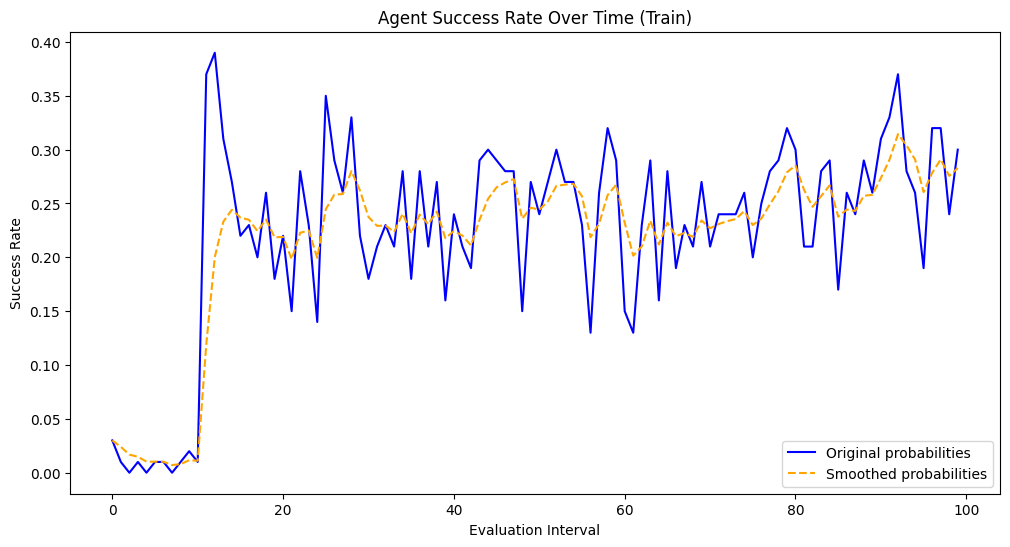

In [13]:
import matplotlib.pyplot as plt

def exponential_smooth(data, alpha=0.3): # Экспоненциальное сглаживание
    smoothed = [data[0]]  # Начинаем с первого значения
    for point in data[1:]:
        smoothed.append(alpha * point + (1 - alpha) * smoothed[-1])
    return smoothed

# Построение графика
plt.figure(figsize=(12, 6))
plt.plot(probs, label='Original probabilities', color='blue')
plt.plot(exponential_smooth(probs), label='Smoothed probabilities', color='orange', linestyle='--')

plt.xlabel('Evaluation Interval')
plt.ylabel('Success Rate')
plt.title('Agent Success Rate Over Time (Train)')
plt.legend()
plt.show()

# Математическое решение

In [7]:
def rule_of_37(num_candidates, num_tests=100000):
    """Функция для проверки алгоритмического правила 37%."""
    rule_success = 0
    for _ in range(num_tests):
        candidates = np.random.permutation(num_candidates)  # случайные кандидаты
        num_to_reject = int(0.37 * num_candidates)  # Отказ от первых 37% кандидатов
        best_seen = max(candidates[:num_to_reject])  # Лучшая оценка среди первых 37%
        
        # Выбираем первого кандидата, который превосходит всех отвергнутых
        selected = None
        for candidate in candidates[num_to_reject:]:
            if candidate > best_seen:
                selected = candidate
                break
        
        # Проверка, является ли выбранный кандидат лучшим из всех
        if selected == num_candidates - 1:  # Наилучший кандидат имеет максимальный рейтинг
            rule_success += 1
    
    rule_success_rate = rule_success / num_tests
    print(f"Процент успеха правила 37%: {rule_success_rate * 100:.2f}%")
    return rule_success_rate


# Сравнение

In [ ]:
# Процент успеха математического решения
_ = rule_of_37(100)

Процент успеха правила 37%: 37.12%


0.37123

In [9]:
agent_rate = eval_agent(env, model, num_tests=1000)
print(f"Процент успеха правила агента: {agent_rate * 100:.2f}%")

Процент успеха правила агента: 38.50%


При увеличении num_tests должно сходиться к 37